In [69]:
import sys
AUX_PATH = '/home/nata/Projects/Active/src'
if AUX_PATH not in sys.path:
    sys.path.insert(0, AUX_PATH)
import utils
import preprocessing
import models
import tournament

import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import datetime as dt

from joblib import Parallel, delayed
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import TimeSeriesSplit

warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
ex = pd.read_csv('../data/temp/magnit_curd_prep.csv')
ex['product'] = ex['key'].str.split("_", n = 1, expand = True)[0]
ex['tbt'] = ex['key'].str.split("_", n = 1, expand = True)[1]
ex = utils.add_cat_cust(ex)
ex['key'] = ex['product']+"_"+ex['Chain']

ex = ex.drop(columns=['product', 'tbt'])
ex= ex.groupby(['Date', 'key'], as_index=False).agg({'Ordered':'sum', 
                                      'Discount on date':'mean',
                                       'Promo_day_num':'mean', 
                                      'SHIP_START':'first', 
                                      'Stor Discount on date':'mean', 
                                      'FT_SHIP_START':'first',
                                       'train/test/fc':'first', 
                                      'Y':'mean', 
                                      'M':'mean', 
                                      'W':'mean', 
                                      'DoM':'mean', 
                                      'DoW':'mean', 
                                      'DoY':'mean', 
                                      'HY':'mean', 
                                      'Q':'mean', 
                                      'S':'mean',
                                       'PINC':'mean', 
                                      'ON_TOP':'sum', 
                                      'ROTATION':'sum', 
                                      'count_delist_sku':'sum',
                                                     'seasonal':'sum',
                                                     'Profile':'sum',
                                                     'max_value_day':'sum'})

ex.head()

Date          key  Ordered  Discount on date  Promo_day_num  \
0  2018-01-01  0026_MAGNIT  458.400               0.0            0.0   
1  2018-01-01  0045_MAGNIT  188.240               0.0            0.0   
2  2018-01-01  0097_MAGNIT   13.824               0.0            0.0   
3  2018-01-01  0165_MAGNIT   18.720               0.0            0.0   
4  2018-01-01  0229_MAGNIT  190.400               0.0            0.0   

  SHIP_START  Stor Discount on date FT_SHIP_START train/test/fc     Y  ...  \
0          0                      0             0    train/test  2018  ...   
1          0                      0             0    train/test  2018  ...   
2          0                      0             0    train/test  2018  ...   
3          0                      0             0    train/test  2018  ...   
4          0                      0             0    train/test  2018  ...   

   HY  Q  S  PINC  ON_TOP  ROTATION  count_delist_sku  seasonal  Profile  \
0   1  1  1   0.0     0.0       0.0               0.0       0.0      0.0   
1   1  1  1   0.0     0.0       0.0               0.0       0.0      0.0   
2   1  1  1   0.0     0.0       0.0               0.0       0.0      0.0   
3   1  1  1   0.0     0.0       0.0               0.0       0.0      0.0   
4   1  1  1   0.0     0.0       0.0               0.0       0.0      0.0   

   max_value_day  
0              0  
1              0  
2              0  
3              0  
4              0  

[5 rows x 25 columns]

1911.1141111111124


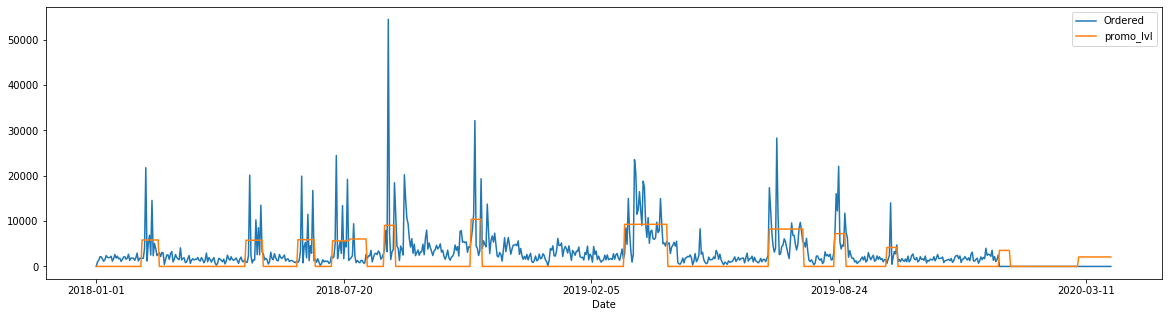

In [85]:
from sklearn.linear_model import LinearRegression
tmp = ex[ex['key']=='0165_MAGNIT']
tmp_base = tmp[(tmp['train/test/fc']=='train/test')&(tmp['Discount on date']==0)].tail(90)['Ordered'].mean()  ##,дневной безлайн для обрезки снизу
tmp['TMP_SHIP_START'] = np.where(tmp['train/test/fc']=='train/test', tmp['SHIP_START'], tmp['FT_SHIP_START'])
tmp_promo = tmp[tmp['TMP_SHIP_START'].astype(str)!='0'].groupby(['key', 'TMP_SHIP_START'], as_index=False).agg({'Ordered':'sum',
                                                                                                          'Promo_day_num':'max',
                                                                                                       'train/test/fc':'last'})
tmp_promo['Daily_vol'] = tmp_promo['Ordered']/tmp_promo['Promo_day_num']
tmp_promo['MA'] = tmp_promo['Daily_vol'].rolling(window=5, win_type='hamming', min_periods=1, center=True).mean()
model = LinearRegression()
X = tmp_promo[tmp_promo['train/test/fc']=='train/test'].index[-5:].values.reshape(-1, 1)
y = tmp_promo[tmp_promo['train/test/fc']=='train/test']['MA'][-5:]
model.fit(X, y)
res = model.predict(tmp_promo[tmp_promo['train/test/fc']!='train/test'].index.values.reshape(-1, 1))
tmp_promo['promo_lvl'] = tmp_promo[tmp_promo['train/test/fc']=='train/test']['MA'].tolist() + res.tolist()
tmp_promo['base'] = tmp_base
tmp_promo['promo_lvl'] = np.maximum(tmp_promo['promo_lvl'], tmp_promo['base'] )
tmp = pd.merge(tmp, tmp_promo[['key', 'TMP_SHIP_START', 'promo_lvl']], how='left', on=['key', 'TMP_SHIP_START']).fillna(0)
tmp = tmp.drop(columns=['TMP_SHIP_START'])
print(tmp_base)
# tmp_promo[['Daily_vol', 'promo_lvl']].plot(figsize=(20, 5))
tmp[['Date', 'Ordered', 'promo_lvl']].plot(figsize=(20, 5), x='Date')

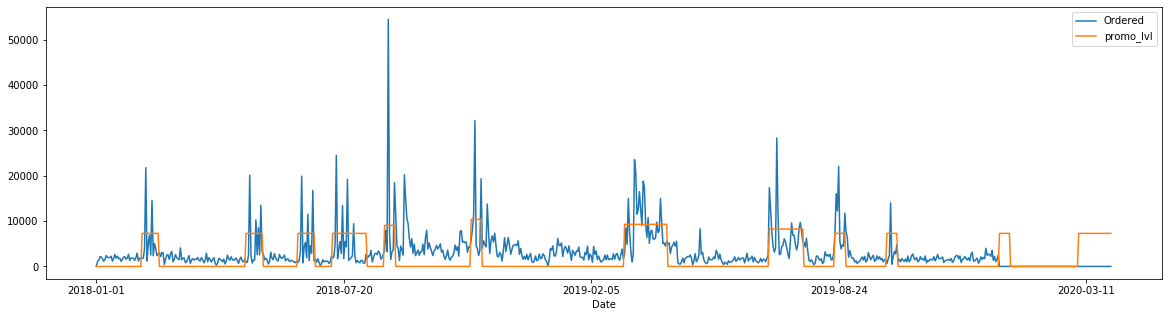

In [63]:
tmp[['Date', 'Ordered', 'promo_lvl']].plot(x='Date', figsize=(20, 5))

In [2]:
%%time
ex = pd.read_csv('../data/temp/magnit_curd_prep.csv')##препроцесснутые данные
tmp = ex#[ex['key']=='0502_850163613']
res_list = []
for key, df in tmp.groupby('key'):
# df = ex[ex['key']=='0502_850163613']
    df = df[df['Discount on date']>0]
    df['SHIP_START'] = np.where(df['train/test/fc']=='train/test', df['SHIP_START'], df['FT_SHIP_START'])
    df_copy = df.copy()
    df = df.groupby(['key', 'SHIP_START'], as_index=False).agg({'train/test/fc':'first',
                                                                'M':'first',
                                                                'Y':'first',
                                                                'S':'first',
                                                                'Q':'first',
                                                                'Discount on date':'max',
                                                                'Ordered':'sum',
                                                                'Promo_day_num':'max'
                                                                })
#     df['MA'] = df['Ordered'].rolling(window=5, win_type='hamming', min_periods=1, center=True).mean()
    cols = ['M', 'Y', 'S', 'Q', 'Discount on date', 'Promo_day_num']
    y = df['Ordered']
    X = df[cols]

    X_train, X_test = X[df['train/test/fc']=='train/test'], X[df['train/test/fc']!='train/test']
    y_train, y_test = y[df['train/test/fc']=='train/test'], y[df['train/test/fc']!='train/test']
    if len(X_train)==0:
        continue
    model = xgb.XGBRegressor()

    model.fit(X_train, y_train)
    pred = model.predict(X)
    df['Forecast'] = pred/df['Promo_day_num']
    # df['SHIP_START'] = df['SHIP_START'].astype(str)
    df_copy = pd.merge(df_copy, df[['key', 'SHIP_START', 'Forecast']], how='left', on=['key', 'SHIP_START']).fillna(0)
    df_copy['FT_SHIP_START'] = df_copy['FT_SHIP_START'].apply(lambda x: str(x)[:10])
    df_copy['SHIP_START'] = df_copy['SHIP_START'].astype(str).apply(lambda x: str(x)[:10])
    res_list.append(df_copy)
results = pd.concat(res_list)
utils.metrics_promo(results)

KeyError: "['Unnamed: 0'] not found in axis"

другой вариант - без группировки по слотам:

In [ ]:
%%time
ex = pd.read_csv('../data/temp/magnit_curd_prep.csv')##препроцесснутые данные
ex = ex.drop(columns = ['Unnamed: 0'])
tmp = ex#[ex['key']=='0502_850163613']
res_list = []
for key, df in tmp.groupby('key'):
# df = ex[ex['key']=='0502_850163613']
    df = df[df['Discount on date']>0]
#     df['SHIP_START'] = np.where(df['train/test/fc']=='train/test', df['SHIP_START'], df['FT_SHIP_START'])
    df_copy = df.copy()
#     df = df.groupby(['key', 'SHIP_START'], as_index=False).agg({'train/test/fc':'first',
#                                                                 'M':'first',
#                                                                 'Y':'first',
#                                                                 'S':'first',
#                                                                 'Q':'first',
#                                                                 'Discount on date':'max',
#                                                                 'Ordered':'sum',
#                                                                 'Promo_day_num':'max'
#                                                                 })
#     df['MA'] = df['Ordered'].rolling(window=30, win_type='hamming', min_periods=1, center=True).mean()
#     это напоминание о том, что неплохо бы добавить MAvg
    cols = ['Discount on date','Promo_day_num', 'Y','M','W','DoM','DoW','DoY','HY','Q','S', 'PINC', 'ON_TOP', 'ROTATION', 'count_delist_sku', 'MA']
    #['M', 'Y', 'S', 'Q', 'Discount on date', 'Promo_day_num']
    y = df['Ordered']
    X = df[cols]

    X_train, X_test = X[df['train/test/fc']=='train/test'], X[df['train/test/fc']!='train/test']
    y_train, y_test = y[df['train/test/fc']=='train/test'], y[df['train/test/fc']!='train/test']
    if len(X_train)==0:
        continue
    model = xgb.XGBRegressor()

    model.fit(X_train, y_train)
    pred = model.predict(X)
    df['Forecast'] = pred
    # df['SHIP_START'] = df['SHIP_START'].astype(str)
    df_copy = pd.merge(df_copy, df[['Date', 'key', 'Forecast']], how='left', on=['Date', 'key']).fillna(0)
    df_copy['FT_SHIP_START'] = df_copy['FT_SHIP_START'].apply(lambda x: str(x)[:10])
    df_copy['SHIP_START'] = df_copy['SHIP_START'].astype(str).apply(lambda x: str(x)[:10])
    res_list.append(df_copy)
results = pd.concat(res_list)
utils.metrics_promo(results)